# Building a Handwritten Digits Classifier

# Handwritten Digits Classifier

## Challenges of image classification:
- Each pixel is a feature, which means we could have millions of features for one single image (A pixels x B pixels = n features)
- In order to reduce computation times, images are reduced and transformed to grayscale, so there is a loss of detail that hurts our model.
- Non-linear behavior: The features of handwritten digits do not present a linear relationship -pixels will be completely different depending on the number written and the writing itself.

## Deep learning as a solution
Deep learning can learn intermediate representations at each hidden layer we define, identifying patterns in chunks.
To create our handwritten digits classifier, we will use a basic deep learning model.

Using `sklearn.datasets` and `load_digits()` function to return a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import pandas as pd # Data processing
import numpy as np # Linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
# %config InlineBackend.figure_format = 'retina' 
# plt.rcParams['figure.figsize'] = 8, 5
# plt.rcParams['image.cmap'] = 'viridis'

from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier


### Helper Functions ###

def explore_number(index,data=load_digits()):
    """Prints following data from digits:
        Numpy 2D array
        Image representation of handwritten number
        Target value (actual number)
    
    Args:
        index of number to be explored
        data (dictionary of data): load_digits() or similar dict structura
    
    Returns:
        Nothing
    """
    print("Handwritten Digit Features - 2D Array")
    print("Target Number {}".format(data['target'][index]))
    print("-------------------------------------")
    for row in data['images'][index]:
        print(row)
    print('\n')
    plt.imshow(data['images'][index], cmap='gray_r')
    plt.xlabel('Target Number {}'.format(data['target'][index]), fontsize=18)
    plt.show()

In [2]:
# Importing the dataset
dataset = load_digits()
dataset.keys() # Keys of dataset

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

Handwritten Digit Features - 2D Array
Target Number 6
-------------------------------------
[ 0.  0.  0.  8. 15.  1.  0.  0.]
[ 0.  0.  0. 12. 14.  0.  0.  0.]
[ 0.  0.  3. 16.  7.  0.  0.  0.]
[ 0.  0.  6. 16.  2.  0.  0.  0.]
[ 0.  0.  7. 16. 16. 13.  5.  0.]
[ 0.  0. 15. 16.  9.  9. 14.  0.]
[ 0.  0.  3. 14.  9.  2. 16.  2.]
[ 0.  0.  0.  7. 15. 16. 11.  0.]




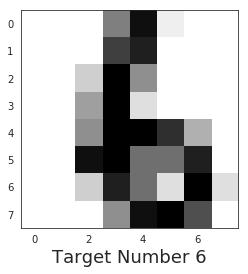

In [3]:
explore_number(16) # Exploring index 16 features and target

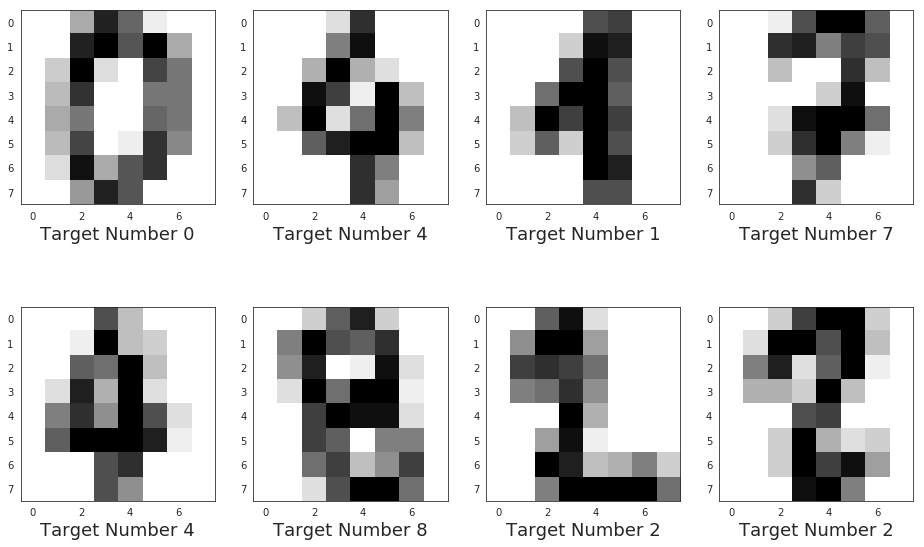

In [4]:
# Visualizing some random data
fig = plt.figure(figsize=(16,10))
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(dataset['images'][i*100], cmap='gray_r') # Showing 2D Numpy arrays as images
    ax.set_xlabel('Target Number {}'.format(dataset['target'][i*100]), fontsize=18) # Add actual number (target) as label

## Defining the train and test data

In [5]:
from sklearn.model_selection import train_test_split

X=dataset['data'] # features
y=dataset['target'] # target values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0
)

## KNN classifier
In order to make image classification with a KNN algorithm, we will use the features in `dataset['data']` and the target values in `dataset['target']`.

In [6]:
def train_knn(X_train,y_train,k=5):
    """Creates a KNN classifier object
    
    Args:
        X_train: Train feature values
        y_train: Train target values
        k: Number of neighbors
    
    Returns:
        KNeighborsClassifier object -see scikit-learn documentation for more details
    """
    knc = KNeighborsClassifier(n_neighbors=k)
    knc.fit(X_train,y_train)
    return knc

def test_knn(model,X_test,y_test,cv=3):
    """Calculates the accuracy of each fold using a KNN trained model
    
    Args:
        model: KNeighborsClassifier object
        X_test: Test feature values
        y_test: Test target values
        cv: Number of folds
    
    Returns:
        Array with cv values, where each of the values is the accuracy of each fold
    """
    predictions = model.predict(X_test)
    accuracy = cross_val_score(model,X_test,y_test,cv=cv) # using cv=3 by default
    return accuracy

knc_model = train_knn(X_train,y_train,k=3)
accuracy_k_3 = test_knn(knc_model,X_test,y_test)

print("KNN accuracy scores for k=3")
print("-----------------------")
for i in range(3):
    print(round(accuracy_k_3[i],2))

KNN accuracy scores for k=3
-----------------------
0.97
0.98
0.97


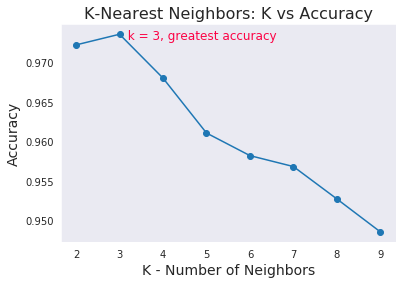

In [7]:
accuracies = list()
accuracies_means = list()

for i in range(2,10):
    knc_model = train_knn(X_train,y_train,k=i)
    accuracy = test_knn(knc_model,X_test,y_test)
    accuracies.append(accuracy)
    accuracies_means.append(np.mean(accuracy)) # we will use the mean of the folds as accuracy metric

sns.set_style('dark')
plt.xlabel('K - Number of Neighbors',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title("K-Nearest Neighbors: K vs Accuracy",fontsize=16)
plt.plot([i for i in range(2,10)],accuracies_means,linestyle='-', marker='o');
plt.annotate('  k = 3, greatest accuracy',(3,.973),color="#fc0345",fontsize=12);

Downsides of k-nearest neighbors:
- Any time we run the code or add any new results, we have to train and test the model, which requires using more memory than other models
- We cannot represent the model -knn is rather an algorithm, not a model, since we have to run it anytime we want to predict a value

## Multi-layer Perception Classifier (MLP)

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def train_mlp(X_train,y_train,n_neurons=8,n_hidden_layers=1,activation='logistic'):
    """Creates a MLP model using a single hidden layer and an activation function
    
    Args:
        X_train: Train feature values
        y_train: Train target values
        n_neurons: Number of neurons in hidden layer
    
    Returns:
        MLPClassifier object -see scikit-learn documentation for more details
    """
    layer_size=tuple(n_neurons for i in range(n_hidden_layers))
    mlp = MLPClassifier(hidden_layer_sizes=layer_size, activation=activation, 
                        max_iter=200, random_state=0, learning_rate_init=.01,
                        early_stopping=True)
    mlp.fit(X_train,y_train)
    return mlp

@ignore_warnings(category=ConvergenceWarning)
def test_mlp(model,X_test,y_test,cv=4):
    """Calculates the accuracy of each cross validation fold using a MLP trained model
    
    Args:
        model: MLPClassifier object
        X_test: Test feature values
        y_test: Test target values
        cv: Number of folds
    
    Returns:
        Array with k values, where each of the values is the accuracy of each fold
    """
    predictions = model.predict(X_test)
    accuracy = cross_val_score(model,X_test,y_test,cv=cv)  # using cv=4 by default
    return accuracy

mlp_model = train_mlp(X_train,y_train)
accuracy_n_8 = test_mlp(mlp_model,X_test,y_test)

print("MLP accuracy scores for n_neurons = 8")
print("Number of hidden layers = 1")
print("-------------------------------------")
for i in range(3):
    print(round(accuracy_n_8[i],2))

MLP accuracy scores for n_neurons = 8
Number of hidden layers = 1
-------------------------------------
0.74
0.78
0.71


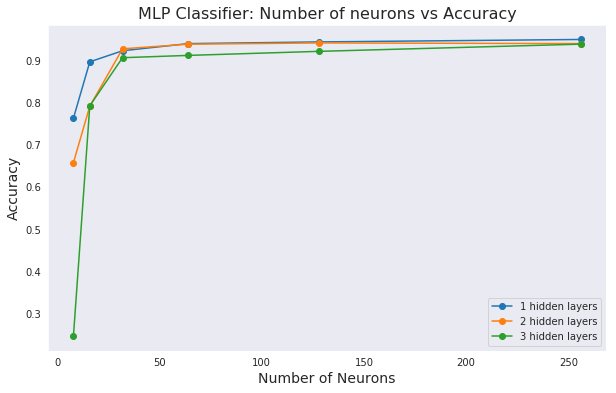

In [9]:
accuracies_mlp = dict()
accuracies_means_mlp = dict()

n_neurons_vals = [8, 16, 32, 64, 128, 256]
n_hidden_layers_vals = [1,2,3]

sns.set_style('dark')
plt.figure(figsize=(10,6))

for m in n_hidden_layers_vals:
    accuracies_mlp['{}_layers'.format(m)] = list()
    accuracies_means_mlp['{}_layers'.format(m)] = list()
    for n in n_neurons_vals:
        mlp_model = train_mlp(X_train,y_train,n_neurons=n,n_hidden_layers=m)
        accuracy = test_mlp(mlp_model,X_test,y_test)
        accuracies_mlp['{}_layers'.format(m)].append(accuracy)
        accuracies_means_mlp['{}_layers'.format(m)].append(np.mean(accuracy)) # we will use the mean of the folds as accuracy metric

    plt.plot(n_neurons_vals,accuracies_means_mlp['{}_layers'.format(m)],linestyle='-', marker='o',label='{} hidden layers'.format(m));

plt.title("MLP Classifier: Number of neurons vs Accuracy".format(1),fontsize=16)
plt.xlabel('Number of Neurons',fontsize=14)
plt.ylabel('Accuracy',fontsize=14);
plt.legend();

## To-do:
- Cross validate using random forests
- Compare max accuracy using KNN, MLP classifier and random forests (bar plot)
- Use Tensorflow/Pytorch and compare results